# Import

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import math
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Data Load

In [2]:
train = pd.read_csv('../new_open/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('../new_open/test.csv').drop(columns=['SAMPLE_ID'])

# Data Pre-processing

In [3]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

In [4]:
# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

In [5]:
# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']


for feature in tqdm(categorical_features, desc="Encoding features"):
    encoder = LabelEncoder()
    train[feature] = encoder.fit_transform(train[feature])
    for label in np.unique(test[feature]):
        if label not in encoder.classes_:
            encoder.classes_ = np.append(encoder.classes_, label)
    test[feature] = encoder.transform(test[feature])

Encoding features: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:11<00:00,  1.91s/it]


In [6]:
# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

C:\Users\pc\AppData\Local\Temp\ipykernel_54328\3687844134.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  train.fillna(train.mean(), inplace=True)
C:\Users\pc\AppData\Local\Temp\ipykernel_54328\3687844134.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  test.fillna(train.mean(), inplace=True)


In [7]:
train.isna().sum()

ARI_CO                0
ARI_PO                0
SHIP_TYPE_CATEGORY    0
DIST                  0
ATA                   0
ID                    0
BREADTH               0
BUILT                 0
DEADWEIGHT            0
DEPTH                 0
DRAUGHT               0
GT                    0
LENGTH                0
SHIPMANAGER           0
FLAG                  0
U_WIND                0
V_WIND                0
AIR_TEMPERATURE       0
BN                    0
ATA_LT                0
PORT_SIZE             0
CI_HOUR               0
year                  0
month                 0
day                   0
hour                  0
minute                0
weekday               0
dtype: int64

In [8]:
test.isna().sum()

ARI_CO                0
ARI_PO                0
SHIP_TYPE_CATEGORY    0
DIST                  0
ATA                   0
ID                    0
BREADTH               0
BUILT                 0
DEADWEIGHT            0
DEPTH                 0
DRAUGHT               0
GT                    0
LENGTH                0
SHIPMANAGER           0
FLAG                  0
U_WIND                0
V_WIND                0
AIR_TEMPERATURE       0
BN                    0
ATA_LT                0
PORT_SIZE             0
year                  0
month                 0
day                   0
hour                  0
minute                0
weekday               0
dtype: int64

# Data Generation

In [9]:
# ATA_LT SIN-COS
train['COS_ATA_LT'] = np.cos(2*np.pi*(train.ATA_LT/24))
train['SIN_ATA_LT'] = np.sin(2*np.pi*(train.ATA_LT/24))

test['COS_ATA_LT'] = np.cos(2*np.pi*(test.ATA_LT/24))
test['SIN_ATA_LT'] = np.sin(2*np.pi*(test.ATA_LT/24))

In [10]:
# USD
# 1. Load the USD data
usd_data = pd.read_csv("../new_open/USD.csv")

# 2. Convert the '날짜' column in USD data to datetime format
usd_data['날짜'] = pd.to_datetime(usd_data['날짜'], format='%Y-%m-%d').dt.date

# Convert the 'ATA' column in train and test data to only the date format
train['ATA_date'] = pd.to_datetime(train['ATA']).dt.date
test['ATA_date'] = pd.to_datetime(test['ATA']).dt.date

# 3. Merge the USD data with train and test data on the date columns
train_merged = pd.merge(train, usd_data, left_on='ATA_date', right_on='날짜', how='left')
test_merged = pd.merge(test, usd_data, left_on='ATA_date', right_on='날짜', how='left')

# Drop the '날짜' and 'ATA_date' columns from merged datasets as they are redundant
train_merged.drop(['날짜', 'ATA_date'], axis=1, inplace=True)
test_merged.drop(['날짜', 'ATA_date'], axis=1, inplace=True)
train_merged.drop(['거래량', '변동 %'],axis=1,inplace=True)
test_merged.drop(['거래량', '변동 %'],axis=1,inplace=True)
train_merged.drop(['시가', '고가', '저가'],axis=1,inplace=True)
test_merged.drop(['시가', '고가', '저가'],axis=1,inplace=True)
train_merged['종가'] = train_merged['종가'].str.replace(',', '').astype(float)
test_merged['종가'] = test_merged['종가'].str.replace(',', '').astype(float)
train = train_merged.copy()
test = test_merged.copy()

In [11]:
# round_hour
train['rounded_hour'] = (train['ATA'].dt.hour + (train['ATA'].dt.minute // 30)).apply(lambda x: 0 if x == 24 else x)
test['rounded_hour'] = (test['ATA'].dt.hour + (test['ATA'].dt.minute // 30)).apply(lambda x: 0 if x == 24 else x)

In [12]:
# Date SIN-COS
# sin, cos 변환 함수 정의
def encode_cyclic_feature(data, column, max_val):
    data[column + '_sin'] = np.sin(2 * np.pi * data[column] / max_val)
    data[column + '_cos'] = np.cos(2 * np.pi * data[column] / max_val)
    return data

# 각 피처에 대해 sin, cos 변환 수행
train = encode_cyclic_feature(train, 'month', 12)
train = encode_cyclic_feature(train, 'day', 31)
train = encode_cyclic_feature(train, 'weekday', 7)
train = encode_cyclic_feature(train, 'rounded_hour', 24)
test = encode_cyclic_feature(test, 'month', 12)
test = encode_cyclic_feature(test, 'day', 31)
test = encode_cyclic_feature(test, 'weekday', 7)
test = encode_cyclic_feature(test, 'rounded_hour', 24)

train.drop(['ATA'],axis=1,inplace=True)
test.drop(['ATA'],axis=1,inplace=True)

C:\Users\pc\anaconda3\envs\HD\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\pc\anaconda3\envs\HD\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\pc\anaconda3\envs\HD\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\pc\anaconda3\envs\HD\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(1, 10))

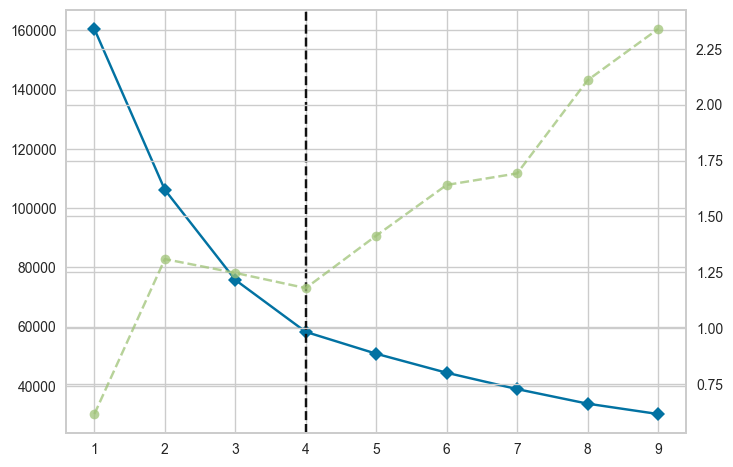

In [13]:
# Ship info category

ship_info = ['SHIP_TYPE_CATEGORY','BREADTH','BUILT','DEADWEIGHT','DEPTH','DRAUGHT','GT','LENGTH','FLAG']

train_data = train[ship_info]
test_data = test[ship_info]

scaler = MinMaxScaler()
train_data_scale = scaler.fit_transform(train_data)
test_data_scale = scaler.transform(test_data)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(train_data_scale)

In [14]:
k = 4

# 그룹 수, random_state 설정
model = KMeans(n_clusters = k, random_state = 10)

# 정규화된 데이터에 학습
model.fit(train_data_scale)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
train['ship_cluster'] = model.fit_predict(train_data_scale)
test['ship_cluster'] = model.predict(test_data_scale)

C:\Users\pc\anaconda3\envs\HD\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\pc\anaconda3\envs\HD\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Info

In [15]:
trian_target = train['CI_HOUR']
train.drop(['CI_HOUR'],axis=1,inplace=True)
train['CI_HOUR'] = trian_target

In [16]:
print(train.shape)
print(test.shape)

(391939, 40)
(220491, 39)


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391939 entries, 0 to 391938
Data columns (total 40 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391939 non-null  int32  
 1   ARI_PO              391939 non-null  int32  
 2   SHIP_TYPE_CATEGORY  391939 non-null  int32  
 3   DIST                391939 non-null  float64
 4   ID                  391939 non-null  int32  
 5   BREADTH             391939 non-null  float64
 6   BUILT               391939 non-null  int64  
 7   DEADWEIGHT          391939 non-null  int64  
 8   DEPTH               391939 non-null  float64
 9   DRAUGHT             391939 non-null  float64
 10  GT                  391939 non-null  int64  
 11  LENGTH              391939 non-null  float64
 12  SHIPMANAGER         391939 non-null  int32  
 13  FLAG                391939 non-null  int32  
 14  U_WIND              391939 non-null  float64
 15  V_WIND              391939 non-nul

In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220491 entries, 0 to 220490
Data columns (total 39 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              220491 non-null  int32  
 1   ARI_PO              220491 non-null  int32  
 2   SHIP_TYPE_CATEGORY  220491 non-null  int32  
 3   DIST                220491 non-null  float64
 4   ID                  220491 non-null  int32  
 5   BREADTH             220491 non-null  float64
 6   BUILT               220491 non-null  int64  
 7   DEADWEIGHT          220491 non-null  int64  
 8   DEPTH               220491 non-null  float64
 9   DRAUGHT             220491 non-null  float64
 10  GT                  220491 non-null  int64  
 11  LENGTH              220491 non-null  float64
 12  SHIPMANAGER         220491 non-null  int32  
 13  FLAG                220491 non-null  int32  
 14  U_WIND              220491 non-null  float64
 15  V_WIND              220491 non-nul

In [19]:
train.isna().sum()

ARI_CO                0
ARI_PO                0
SHIP_TYPE_CATEGORY    0
DIST                  0
ID                    0
BREADTH               0
BUILT                 0
DEADWEIGHT            0
DEPTH                 0
DRAUGHT               0
GT                    0
LENGTH                0
SHIPMANAGER           0
FLAG                  0
U_WIND                0
V_WIND                0
AIR_TEMPERATURE       0
BN                    0
ATA_LT                0
PORT_SIZE             0
year                  0
month                 0
day                   0
hour                  0
minute                0
weekday               0
COS_ATA_LT            0
SIN_ATA_LT            0
종가                    0
rounded_hour          0
month_sin             0
month_cos             0
day_sin               0
day_cos               0
weekday_sin           0
weekday_cos           0
rounded_hour_sin      0
rounded_hour_cos      0
ship_cluster          0
CI_HOUR               0
dtype: int64

In [20]:
test.isna().sum()

ARI_CO                0
ARI_PO                0
SHIP_TYPE_CATEGORY    0
DIST                  0
ID                    0
BREADTH               0
BUILT                 0
DEADWEIGHT            0
DEPTH                 0
DRAUGHT               0
GT                    0
LENGTH                0
SHIPMANAGER           0
FLAG                  0
U_WIND                0
V_WIND                0
AIR_TEMPERATURE       0
BN                    0
ATA_LT                0
PORT_SIZE             0
year                  0
month                 0
day                   0
hour                  0
minute                0
weekday               0
COS_ATA_LT            0
SIN_ATA_LT            0
종가                    0
rounded_hour          0
month_sin             0
month_cos             0
day_sin               0
day_cos               0
weekday_sin           0
weekday_cos           0
rounded_hour_sin      0
rounded_hour_cos      0
ship_cluster          0
dtype: int64

In [21]:
display(train.head())
display(test.head())

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,rounded_hour_sin,rounded_hour_cos,ship_cluster,CI_HOUR
0,17,21,2,30.881018,24710,30.0,24,24300,10.0,10.0,...,-2.449294e-16,1.000000e+00,-0.299363,-0.954139,0.000000,1.000000,-0.707107,0.707107,1,3.450000
1,7,81,0,0.000000,23140,30.0,13,35900,10.0,10.0,...,-1.000000e+00,-1.836970e-16,-0.998717,-0.050649,0.781831,0.623490,0.965926,-0.258819,2,0.000000
2,4,14,2,0.000000,19009,50.0,12,146000,30.0,20.0,...,8.660254e-01,5.000000e-01,0.571268,0.820763,0.781831,0.623490,-0.500000,0.866025,3,0.000000
3,8,101,2,0.000000,24048,20.0,18,6910,10.0,10.0,...,5.000000e-01,8.660254e-01,-0.299363,-0.954139,-0.433884,-0.900969,0.866025,0.500000,1,0.000000
4,17,21,2,27.037650,911,50.0,10,116000,20.0,10.0,...,5.000000e-01,8.660254e-01,-0.848644,0.528964,-0.781831,0.623490,0.866025,-0.500000,0,253.554444


,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,rounded_hour,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,rounded_hour_sin,rounded_hour_cos,ship_cluster
0,17,21,2,1.826589,9788,50.0,18,117000,30.0,20.0,...,12,1.224647e-16,-1.000000,-0.485302,-0.874347,0.433884,-0.900969,1.224647e-16,-1.000000e+00,3
1,4,90,1,25.399386,4184,10.0,13,3810,10.0,10.0,...,22,5.000000e-01,-0.866025,-0.848644,0.528964,0.974928,-0.222521,-5.000000e-01,8.660254e-01,1
2,4,45,2,111.079467,5578,20.0,26,10900,10.0,10.0,...,0,-2.449294e-16,1.000000,-0.101168,-0.994869,0.000000,1.000000,0.000000e+00,1.000000e+00,1
3,2,19,0,9.175258,734,30.0,9,55800,20.0,10.0,...,6,-5.000000e-01,0.866025,-0.101168,-0.994869,0.000000,1.000000,1.000000e+00,6.123234e-17,2
4,8,66,2,0.000000,847,30.0,19,39800,20.0,10.0,...,1,-8.660254e-01,0.500000,-0.988468,0.151428,0.974928,-0.222521,2.588190e-01,9.659258e-01,0


# CSV

In [ ]:
train.to_csv('../new_open/train_merge_new_fillna.csv',index=False)
test.to_csv('../new_open/test_merge_new_fillna.csv',index=False)